In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/google')

Mounted at /content/google


In [ ]:
X = []  # Feature data (e.g., MFCCs)
y = []  # Class labels
data_dir = "/content/google/MyDrive/TensorFlow-2.x-YOLOv3/data/"

for class_label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_label)
    if os.path.isdir(class_dir):
        for audio_file in os.listdir(class_dir):
            if audio_file.endswith(".wav"):
                audio_path = os.path.join(class_dir, audio_file)
                audio_data, _ = librosa.load(str(audio_path), sr=44100)
                X.append(audio_data)
                y.append(class_label)

# Extract MFCC features from audio data
def extract_mfcc_features(audio_data, num_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=44100, n_mfcc=num_mfcc)
    return mfccs

X_mfcc = [extract_mfcc_features(audio) for audio in X]


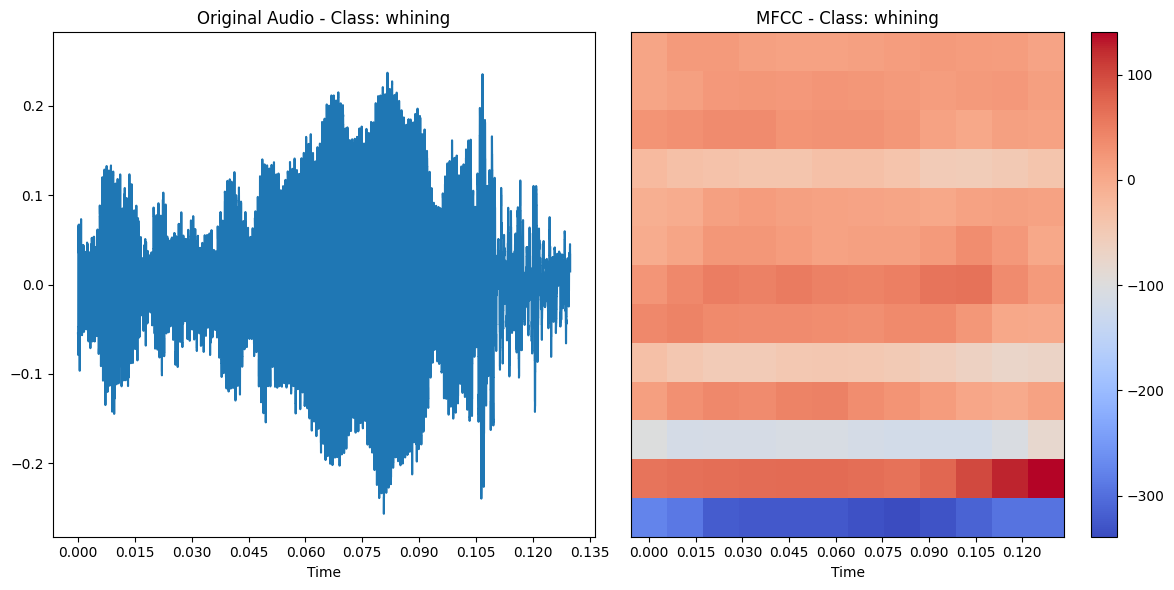

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define function to extract MFCC features from audio data
def extract_mfcc_features(audio_data, num_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=44100, n_mfcc=num_mfcc)
    return mfccs

# Load data and extract features
X = []  # Feature data (e.g., MFCCs)
y = []  # Class labels
data_dir = "/content/google/MyDrive/TensorFlow-2.x-YOLOv3/data/"

for class_label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_label)
    if os.path.isdir(class_dir):
        for audio_file in os.listdir(class_dir):
            if audio_file.endswith(".wav"):
                audio_path = os.path.join(class_dir, audio_file)
                audio_data, _ = librosa.load(str(audio_path), sr=44100)
                X.append(audio_data)
                y.append(class_label)

# Extract MFCC features from audio data
X_mfcc = [extract_mfcc_features(audio) for audio in X]

# Plot a sample of original audio data and the data after MFCC
sample_index = 1  # Change this to plot a different sample
plt.figure(figsize=(12, 6))

# Plot original audio waveform
plt.subplot(1, 2, 1)
librosa.display.waveshow(X[sample_index], sr=44100)
plt.title('Original Audio - Class: {}'.format(y[sample_index]))

# Plot MFCC features
plt.subplot(1, 2, 2)
librosa.display.specshow(X_mfcc[sample_index], sr=44100, x_axis='time')
plt.colorbar()
plt.title('MFCC - Class: {}'.format(y[sample_index]))

plt.tight_layout()
plt.show()


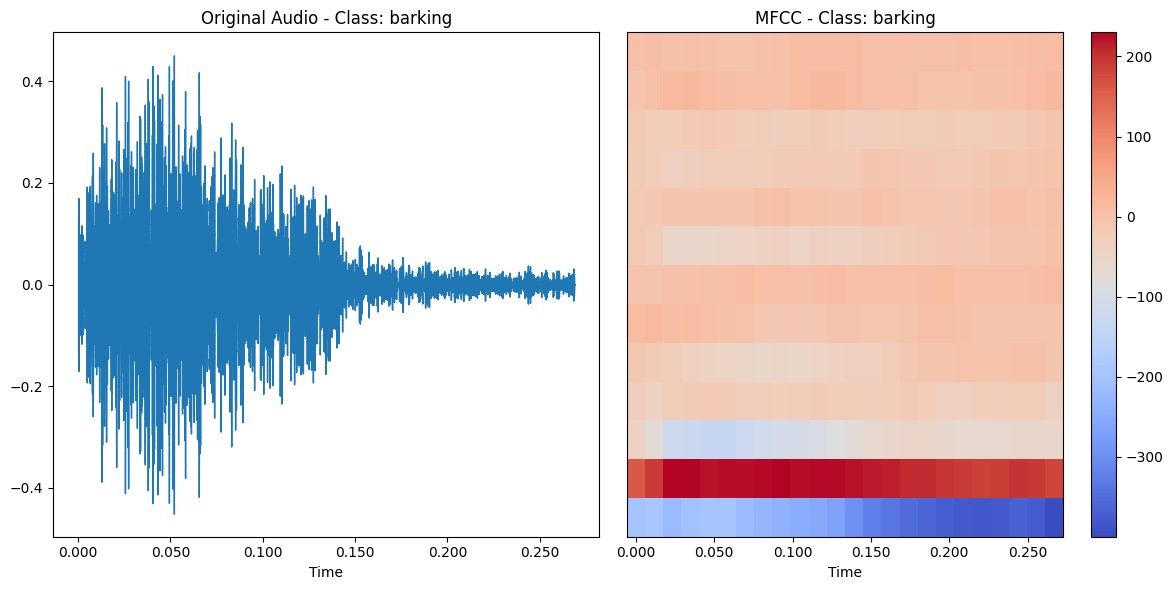

In [ ]:
sample_index = 929  # Change this to plot a different sample
plt.figure(figsize=(12, 6))

# Plot original audio waveform
plt.subplot(1, 2, 1)
librosa.display.waveshow(X[sample_index], sr=44100)
plt.title('Original Audio - Class: {}'.format(y[sample_index]))

# Plot MFCC features
plt.subplot(1, 2, 2)
librosa.display.specshow(X_mfcc[sample_index], sr=44100, x_axis='time')
plt.colorbar()
plt.title('MFCC - Class: {}'.format(y[sample_index]))

plt.tight_layout()
plt.show()

In [ ]:
np.array(X_mfcc[0]).shape

(13, 12)

In [ ]:
X[0].shape

(5728,)

In [ ]:

# Find the maximum number of frames in your MFCC features
max_frames = max(mfcc.shape[1] for mfcc in X_mfcc)

# Create a new array and pad or truncate the MFCC features
X_mfcc_padded = np.zeros((len(X_mfcc), X_mfcc[0].shape[0], max_frames))
for i, mfcc in enumerate(X_mfcc):
    if mfcc.shape[1] < max_frames:
        X_mfcc_padded[i, :, :mfcc.shape[1]] = mfcc  # Pad with zeros if shorter
    else:
        X_mfcc_padded[i, :, :] = mfcc[:, :max_frames]  # Truncate if longer

# Now, you can proceed with normalization as before
mean = np.mean(X_mfcc_padded, axis=2, keepdims=True)
std = np.std(X_mfcc_padded, axis=2, keepdims=True)
X_mfcc_normalized = (X_mfcc_padded - mean) / (std + 1e-6)


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mfcc_normalized, y, test_size=0.2, random_state=12, shuffle=True)

# Reshape MFCC features to match the model's input shape
X_train_reshaped = np.array(X_train)
X_test_reshaped = np.array(X_test)

# Convert class labels to one-hot encoded format
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

In [ ]:
X_train[0].shape

(13, 422)

In [ ]:
label_encoder.fit(y_train)
label_encoder.classes_

array(['barking', 'growling', 'howling', 'whining'], dtype='<U8')

In [ ]:
X_train_reshaped.shape

(960, 13, 422)

In [ ]:
y_train_encoded.shape

(960, 4)

In [ ]:
class LSTM(tf.keras.Model):
    def __init__(self, num_classes, num_conv_layers, num_filters, kernel_size, lstm_units):
        super(LSTM, self).__init__()

        # Define the fully convolutional block
        # self.conv_block = tf.keras.Sequential()

        # for _ in range(num_conv_layers):
        #     self.conv_block.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        #     self.conv_block.add(tf.keras.layers.BatchNormalization())
        # self.conv_block.add(tf.keras.layers.GlobalAveragePooling1D())

        # # Define the LSTM block
        self.lstm_block = tf.keras.Sequential()
        self.lstm_block.add(tf.keras.layers.Permute((2, 1)))
        self.lstm_block.add(tf.keras.layers.LSTM(units=lstm_units))

        # Softmax classification layer
        self.classification_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply the fully convolutional block to the input
        # x1 = self.conv_block(inputs)

        # Apply the LSTM block to the input
        x2 = self.lstm_block(inputs)

        # Concatenate the outputs from both blocks
        x = tf.keras.layers.concatenate([x2], axis=-1)

        # Pass the concatenated output through the classification layer
        output = self.classification_layer(x)

        return output

In [ ]:
class FCN(tf.keras.Model):
    def __init__(self, num_classes, num_conv_layers, num_filters, kernel_size, lstm_units):
        super(FCN, self).__init__()

        # Define the fully convolutional block
        self.conv_block = tf.keras.Sequential()
        for _ in range(num_conv_layers):
            self.conv_block.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))
            self.conv_block.add(tf.keras.layers.BatchNormalization())
        self.conv_block.add(tf.keras.layers.GlobalAveragePooling1D())

        # # Define the LSTM block
        # self.lstm_block = tf.keras.Sequential()
        # self.lstm_block.add(tf.keras.layers.Permute((2, 1)))
        # self.lstm_block.add(tf.keras.layers.LSTM(units=lstm_units))

        # Softmax classification layer
        self.classification_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply the fully convolutional block to the input
        x1 = self.conv_block(inputs)

        # Apply the LSTM block to the input
        # x2 = self.lstm_block(inputs)

        # Concatenate the outputs from both blocks
        x = tf.keras.layers.concatenate([x1], axis=-1)

        # Pass the concatenated output through the classification layer
        output = self.classification_layer(x)

        return output

In [ ]:
class BiLSTM(tf.keras.Model):
    def __init__(self, num_classes, lstm_units):
        super(BiLSTM, self).__init__()

        # Define the BiLSTM block
        self.bilstm_block = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_units))

        # Softmax classification layer
        self.classification_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply the BiLSTM block to the input
        x = self.bilstm_block(inputs)

        # Pass the output through the classification layer
        output = self.classification_layer(x)

        return output

In [ ]:
class LSTM_FCN(tf.keras.Model):
    def __init__(self, num_classes, num_conv_layers, num_filters, kernel_size, lstm_units):
        super(LSTM_FCN, self).__init__()

        # Define the fully convolutional block
        self.conv_block = tf.keras.Sequential()
        for _ in range(num_conv_layers):
            self.conv_block.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))
            self.conv_block.add(tf.keras.layers.BatchNormalization())
        self.conv_block.add(tf.keras.layers.GlobalAveragePooling1D())

        # Define the LSTM block
        self.lstm_block = tf.keras.Sequential()
        self.lstm_block.add(tf.keras.layers.Permute((2, 1)))
        self.lstm_block.add(tf.keras.layers.LSTM(units=lstm_units))

        # Softmax classification layer
        self.classification_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply the fully convolutional block to the input
        x1 = self.conv_block(inputs)

        # Apply the LSTM block to the input
        x2 = self.lstm_block(inputs)

        # Concatenate the outputs from both blocks
        x = tf.keras.layers.concatenate([x1, x2], axis=-1)

        # Pass the concatenated output through the classification layer
        output = self.classification_layer(x)

        return output

In [ ]:
class BiLSTM_FCN(tf.keras.Model):
    def __init__(self, num_classes, num_conv_layers, num_filters, kernel_size, lstm_units):
        super(BiLSTM_FCN, self).__init__()

        # Define the fully convolutional block
        self.conv_block = tf.keras.Sequential()
        for _ in range(num_conv_layers):
            self.conv_block.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))
            self.conv_block.add(tf.keras.layers.BatchNormalization())
        self.conv_block.add(tf.keras.layers.GlobalAveragePooling1D())

        # Define the BiLSTM block
        self.bilstm_block = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_units))

        # Softmax classification layer
        self.classification_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply the fully convolutional block to the input
        x1 = self.conv_block(inputs)

        # Apply the BiLSTM block to the input
        x2 = self.bilstm_block(inputs)

        # Concatenate the outputs from both blocks
        x = tf.keras.layers.concatenate([x1, x2], axis=-1)

        # Pass the concatenated output through the classification layer
        output = self.classification_layer(x)

        return output


In [ ]:
models = []
names = []


# FCN Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 1
num_filters = 64
kernel_size = 3
lstm_units = 64

model = FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("FCN_1")


# FCN-2 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 3
lstm_units = 64

model = FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("FCN_2")

# FCN-3 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 3
num_filters = 64
kernel_size = 3
lstm_units = 64

model = FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("FCN_3")


# FCN-4 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 3
lstm_units = 64

model = FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("FCN_4")


# FCN Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 5
num_filters = 64
kernel_size = 3
lstm_units = 64

model = FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("FCN_5")


# FCN Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 6
num_filters = 64
kernel_size = 3
lstm_units = 64

model = FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("FCN_6")





# LSTM Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 64

model = LSTM(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("LSTM_64")






# LSTM-124 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 124

model = LSTM(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("LSTM_124")

# LSTM-212 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 212

model = LSTM(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("LSTM_212")

# LSTM-212 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 300

model = LSTM(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("LSTM_300")






# BiLSTM 64 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 64

model = BiLSTM(num_classes, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("BiLSTM-64")



# BiLSTM_124 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 124

model = BiLSTM(num_classes, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("BiLSTM-124")

# BiLSTM_212 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 212

model = BiLSTM(num_classes, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("BiLSTM-212")


# BiLSTM_212 Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 300

model = BiLSTM(num_classes, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("BiLSTM-300")



#  LSTM_FCN Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 64

model = LSTM_FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("LSTM_FCN_4_64")


#  LSTM_FCN Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 212

model = LSTM_FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("LSTM_FCN_4_212")



#  LSTM_FCN Model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 300

model = LSTM_FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("LSTM_FCN_4_300")

# BiLSTM FCN
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 3
lstm_units = 64

model = BiLSTM_FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("BiLSTM_FCN_4_64")



# BiLSTM FCN
num_classes = len(label_encoder.classes_)
num_conv_layers = 5
num_filters = 64
kernel_size = 3
lstm_units = 212

model = BiLSTM_FCN(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1_score')])
models.append(model)
names.append("BiLSTM_FCN_5_212")


In [ ]:
import pandas as pd

num_epochs = 25
batch_size = 32
histories = []
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score']

results_dict = {metric: [] for metric in metrics}

for model in models:
    history = model.fit(X_train_reshaped, y_train_encoded, validation_data=(X_test_reshaped, y_test_encoded), epochs=num_epochs, batch_size=batch_size)
    histories.append(history)
    for metric in metrics:
        results_dict[metric].append(history.history[metric][-1])

results_df = pd.DataFrame(results_dict)
results_df["names"] = names
train_results = results_df[["loss",	"accuracy",	"precision",	"recall","f1_score","names"]]
val_results = results_df[["val_loss",	"val_accuracy",	"val_precision",	"val_recall",	"val_f1_score","names"]]


Epoch 1/25
30/30 [==============================] - 3s 31ms/step - loss: 0.4872 - accuracy: 0.8417 - precision: 0.9145 - recall: 0.7688 - f1_score: 0.8405 - val_loss: 0.5937 - val_accuracy: 0.7875 - val_precision: 0.7940 - val_recall: 0.7708 - val_f1_score: 0.7829
Epoch 2/25
30/30 [==============================] - 0s 13ms/step - loss: 0.2792 - accuracy: 0.9146 - precision: 0.9357 - recall: 0.8938 - f1_score: 0.9146 - val_loss: 0.3453 - val_accuracy: 0.8417 - val_precision: 0.8541 - val_recall: 0.8292 - val_f1_score: 0.8391
Epoch 3/25
30/30 [==============================] - 0s 12ms/step - loss: 0.2294 - accuracy: 0.9281 - precision: 0.9419 - recall: 0.9115 - f1_score: 0.9282 - val_loss: 0.2435 - val_accuracy: 0.9125 - val_precision: 0.9224 - val_recall: 0.8917 - val_f1_score: 0.9116
Epoch 4/25
30/30 [==============================] - 0s 12ms/step - loss: 0.1990 - accuracy: 0.9365 - precision: 0.9506 - recall: 0.9229 - f1_score: 0.9363 - val_loss: 0.2332 - val_accuracy: 0.9083 - val_pr

In [ ]:
results_df

,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score,names
0,0.033199,0.996875,0.996875,0.996875,"[0.99368423, 1.0, 1.0, 0.9938145]",0.232302,0.929167,0.929167,0.929167,"[0.984127, 0.88709676, 0.9043478, 0.9391304]",FCN_1
1,0.001539,1.000000,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0]",0.056682,0.979167,0.979167,0.979167,"[1.0, 0.96774197, 0.98275864, 0.9655172]",FCN_2
2,0.002764,1.000000,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0]",0.149895,0.954167,0.953975,0.950000,"[0.992, 0.9193549, 0.94827586, 0.95652175]",FCN_3
3,0.008908,0.996875,0.996875,0.996875,"[0.9937107, 0.9957806, 1.0, 0.99792963]",0.201651,0.937500,0.937239,0.933333,"[0.96666664, 0.9180328, 0.9491526, 0.9166666]",FCN_4
4,0.006699,0.997917,0.997917,0.997917,"[0.9979035, 0.9978947, 0.99793816, 0.99792963]",0.098520,0.975000,0.975000,0.975000,"[0.9918699, 0.96825397, 0.98275864, 0.95652175]",FCN_5
5,0.001291,1.000000,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0]",0.082193,0.970833,0.970833,0.970833,"[1.0, 0.95161283, 0.9655172, 0.9655172]",FCN_6
6,0.201519,0.939583,0.949947,0.929167,"[0.9416499, 0.94845366, 0.9769392, 0.8893709]",0.233288,0.950000,0.948718,0.925000,"[0.9677419, 0.93442625, 0.9491526, 0.94827586]",LSTM_64
7,0.193672,0.939583,0.944444,0.920833,"[0.9628099, 0.9240506, 0.9772257, 0.89352816]",0.150943,0.950000,0.961538,0.937500,"[0.9763779, 0.96, 0.93805313, 0.92173916]",LSTM_124
8,0.157053,0.959375,0.961175,0.954167,"[0.9628099, 0.9626556, 0.97489536, 0.9369748]",0.222228,0.920833,0.924370,0.916667,"[0.93939394, 0.92561984, 0.93103445, 0.8828829]",LSTM_212
9,0.145349,0.951042,0.953927,0.948958,"[0.9726315, 0.9423868, 0.972973, 0.91631794]",0.209840,0.954167,0.953587,0.941667,"[0.983871, 0.92436975, 0.9411765, 0.9661017]",LSTM_300


In [ ]:
val_results

,val_loss,val_accuracy,val_precision,val_recall,val_f1_score,names
0,0.232302,0.929167,0.929167,0.929167,"[0.984127, 0.88709676, 0.9043478, 0.9391304]",FCN_1
1,0.056682,0.979167,0.979167,0.979167,"[1.0, 0.96774197, 0.98275864, 0.9655172]",FCN_2
2,0.149895,0.954167,0.953975,0.950000,"[0.992, 0.9193549, 0.94827586, 0.95652175]",FCN_3
3,0.201651,0.937500,0.937239,0.933333,"[0.96666664, 0.9180328, 0.9491526, 0.9166666]",FCN_4
4,0.098520,0.975000,0.975000,0.975000,"[0.9918699, 0.96825397, 0.98275864, 0.95652175]",FCN_5
5,0.082193,0.970833,0.970833,0.970833,"[1.0, 0.95161283, 0.9655172, 0.9655172]",FCN_6
6,0.233288,0.950000,0.948718,0.925000,"[0.9677419, 0.93442625, 0.9491526, 0.94827586]",LSTM_64
7,0.150943,0.950000,0.961538,0.937500,"[0.9763779, 0.96, 0.93805313, 0.92173916]",LSTM_124
8,0.222228,0.920833,0.924370,0.916667,"[0.93939394, 0.92561984, 0.93103445, 0.8828829]",LSTM_212
9,0.209840,0.954167,0.953587,0.941667,"[0.983871, 0.92436975, 0.9411765, 0.9661017]",LSTM_300


In [ ]:
val_results[["names","val_loss","val_accuracy","val_precision","val_recall"]]

,names,val_loss,val_accuracy,val_precision,val_recall
0,FCN_1,0.232302,0.929167,0.929167,0.929167
1,FCN_2,0.056682,0.979167,0.979167,0.979167
2,FCN_3,0.149895,0.954167,0.953975,0.950000
3,FCN_4,0.201651,0.937500,0.937239,0.933333
4,FCN_5,0.098520,0.975000,0.975000,0.975000
5,FCN_6,0.082193,0.970833,0.970833,0.970833
6,LSTM_64,0.233288,0.950000,0.948718,0.925000
7,LSTM_124,0.150943,0.950000,0.961538,0.937500
8,LSTM_212,0.222228,0.920833,0.924370,0.916667
9,LSTM_300,0.209840,0.954167,0.953587,0.941667


In [ ]:
models[17]

In [ ]:
val_f1_score = results_df[["f1_score","names"]]
val_f1_score["f1_score"][0]

array([0.99368423, 1.        , 1.        , 0.9938145 ], dtype=float32)

In [ ]:
import pandas as pd



classnames = ['barking', 'growling', 'howling', 'whining']
val_f1_scores = val_f1_score["f1_score"]

import pandas as pd

# Sample DataFrame
data = {
    "val_f1_score": val_f1_scores,
}

val_f1_scores_df = pd.DataFrame(data)
val_f1_scores_df["names"] = val_f1_score["names"]

# Create individual columns for each class name
for i, class_name in enumerate(classnames):
    val_f1_scores_df[f'f1_score_{class_name}'] = val_f1_scores_df["val_f1_score"].apply(lambda x: x[i])

# Drop the original column of val_f1_scores
val_f1_scores_df.drop(columns=["val_f1_score"], inplace=True)

val_f1_scores_df

,names,f1_score_barking,f1_score_growling,f1_score_howling,f1_score_whining
0,FCN_1,0.993684,1.000000,1.000000,0.993815
1,FCN_2,1.000000,1.000000,1.000000,1.000000
2,FCN_3,1.000000,1.000000,1.000000,1.000000
3,FCN_4,0.993711,0.995781,1.000000,0.997930
4,FCN_5,0.997904,0.997895,0.997938,0.997930
5,FCN_6,1.000000,1.000000,1.000000,1.000000
6,LSTM_64,0.941650,0.948454,0.976939,0.889371
7,LSTM_124,0.962810,0.924051,0.977226,0.893528
8,LSTM_212,0.962810,0.962656,0.974895,0.936975
9,LSTM_300,0.972632,0.942387,0.972973,0.916318


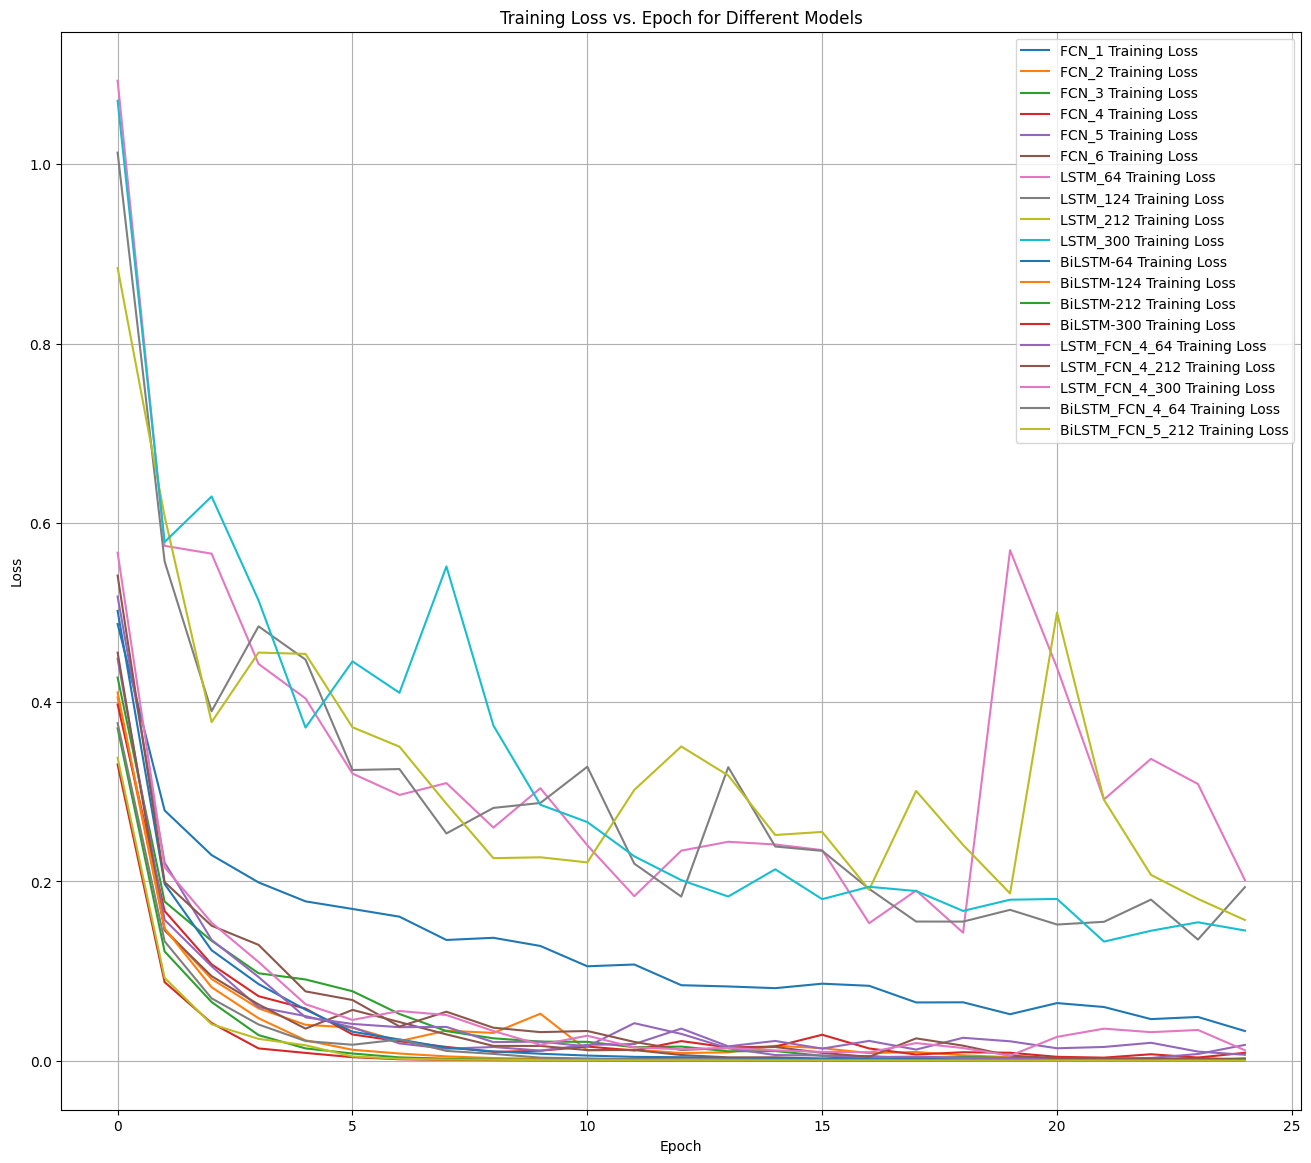

In [ ]:
fig, ax = plt.subplots(figsize=(16, 14))

# Iterate over each model's history and plot training loss
for i in range(len(histories)):
    ax.plot(histories[i].history['loss'], label=f'{names[i]} Training Loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss vs. Epoch for Different Models')
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
len(names)

19

In [ ]:
len(histories)

19

In [ ]:
#Define and compile the LSTM-FCN model
num_classes = len(label_encoder.classes_)
num_conv_layers = 4
num_filters = 64
kernel_size = 2
lstm_units = 64

model = LSTM(num_classes, num_conv_layers, num_filters, kernel_size, lstm_units)
model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(num_classes=num_classes, name='f1_score')])

# Train the model
num_epochs = 10
batch_size = 32
model.fit(X_train_reshaped, y_train_encoded, validation_data=(X_test_reshaped, y_test_encoded), epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
30/30 [==============================] - 8s 201ms/step - loss: 1.0600 - accuracy: 0.6625 - val_loss: 0.7198 - val_accuracy: 0.7958
Epoch 2/10
30/30 [==============================] - 5s 179ms/step - loss: 0.6221 - accuracy: 0.8354 - val_loss: 0.4966 - val_accuracy: 0.8625
Epoch 3/10
30/30 [==============================] - 5s 159ms/step - loss: 0.8138 - accuracy: 0.7167 - val_loss: 0.9242 - val_accuracy: 0.6292
Epoch 4/10
30/30 [==============================] - 6s 211ms/step - loss: 1.1829 - accuracy: 0.5083 - val_loss: 1.2343 - val_accuracy: 0.4625
Epoch 5/10
30/30 [==============================] - 5s 159ms/step - loss: 1.0716 - accuracy: 0.5573 - val_loss: 1.0861 - val_accuracy: 0.6667
Epoch 6/10
30/30 [==============================] - 5s 157ms/step - loss: 0.9506 - accuracy: 0.6885 - val_loss: 0.9183 - val_accuracy: 0.7250
Epoch 7/10
30/30 [==============================] - 6s 204ms/step - loss: 0.7925 - accuracy: 0.7927 - val_loss: 0.7161 - val_accuracy: 0.8500
Epoch 

In [ ]:
# # Evaluate the model on the test data
# loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
# print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


In [ ]:
model = models[17]
predictions = model.predict(X_test_reshaped)


8/8 [==============================] - 2s 16ms/step


In [ ]:
y_pred = model.predict(X_test_reshaped)

8/8 [==============================] - 0s 13ms/step


8/8 [==============================] - 0s 14ms/step


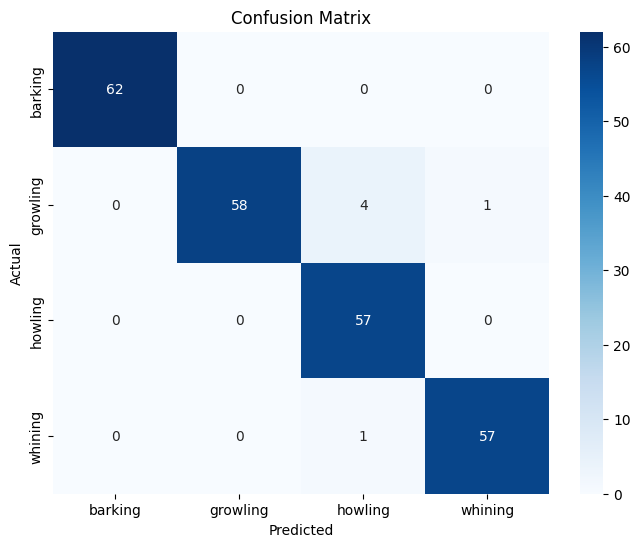

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# # Get predictions on test data
y_pred = model.predict(X_test_reshaped)
y_preds = []
for i in y_pred:
  y_preds.append(np.argmax(i))

y_test = label_encoder.fit_transform(y_test)
conf_matrix = confusion_matrix(y_test, y_preds)
class_labels = label_encoder.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Save the model to a file
model.save_weights("lstm_fcn_model.h5")